In [ ]:
!unzip /content/drive/MyDrive/val_images.zip

In [2]:
!pip install open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x8

In [3]:
import torch
from PIL import Image
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"

In [53]:
model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:ellen625/PatentCLIP_ViT_B', device=device)
tokenizer = open_clip.get_tokenizer('hf-hub:ellen625/PatentCLIP_ViT_B')

In [5]:
def get_single_image_embedding(img):
  image = preprocess(Image.open(img)).unsqueeze(0).to(device)
  with torch.no_grad():
    image_feature = model.encode_image(image).to(device)
  return image_feature


def get_single_text_embedding(text):

  text = tokenizer(text).to(device)
  with torch.no_grad():
    text_feature = model.encode_text(text).to(device)
  return text_feature

In [10]:
import pandas as pd

df = pd.read_csv('val_caption_5k.csv')

In [76]:
from PIL import Image, ImageDraw, ImageFont
def combine_images_side_by_side(images, image_names):
    # Calculate total width and max height
    total_width = sum(image.width for image in images)
    max_height = max(image.height for image in images)

    # Assume text height is 30 pixels (you may need to adjust this based on your font size)
    text_height = 110
    total_height = max_height + text_height

    # Create a new image with the calculated dimensions
    combined_image = Image.new('L', (total_width, total_height), 'white')

    # Prepare to draw text
    draw = ImageDraw.Draw(combined_image)
    # You can specify a font and size here, or omit for default
    font_path = '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf'
    font = ImageFont.truetype(font_path, size=100)

    # Paste each image and write its name
    x_offset = 0
    for image, name in zip(images, image_names):
        combined_image.paste(image, (x_offset, 0))
        # Draw the name below the image
        draw.text((x_offset + image.width // 3 - len(name) * 5, max_height), name, fill="black", font=font)  # Adjust text position as needed
        x_offset += image.width  # Move the offset to the right

    return combined_image

In [11]:
df.head()

,filepath,caption
0,val/val_images/D0911610.TIF,"The image is a drawing of a shaver, which is ..."
1,val/val_images/D0849880.TIF,"The image is in the shape of a fishing lure, ..."
2,val/val_images/D0844635.TIF,"The image is square-shaped, and it displays a..."
3,val/val_images/D1006114.TIF,The image is a square-shaped drawing of a pro...
4,val/val_images/D0839831.TIF,The image is a square-shaped electrical conne...


In [12]:
import os
from PIL import Image
from tqdm import tqdm

In [13]:
folder_path = "val_images/"
df['filepath'] = df['filepath'].str.replace('val/', '', n=1)
file_list = df['filepath'].tolist()
images = [f for f in file_list]
#embedded_images = list(map(lambda x: (x, get_single_image_embedding(x)), tqdm(images)))

In [14]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai', device=device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')
embedded_images = [(x, get_single_image_embedding(x)) for x in tqdm(images)]

# Extract only the embeddings from the list of tuples
img_feature_list = [feature for _, feature in embedded_images]

# Convert list of tensors to a single tensor
image_embeds_clip = torch.cat(img_feature_list, dim=0)

# Normalize the embeddings
image_embeds_clip /= image_embeds_clip.norm(dim=-1, keepdim=True)
embedded_images = [(images[i], image_embeds_clip[i]) for i in range(len(images))]

100%|███████████████████████████████████████| 354M/354M [00:07<00:00, 44.5MiB/s]
100%|██████████| 5000/5000 [01:27<00:00, 56.83it/s]


In [54]:
#embedded_images_pc1 = list(map(lambda x: (x, get_single_image_embedding(x)), tqdm(images)))

100%|██████████| 5000/5000 [05:22<00:00, 15.53it/s]


In [15]:
model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:ellen625/PatentCLIP_ViT_B', device=device)
tokenizer = open_clip.get_tokenizer('hf-hub:ellen625/PatentCLIP_ViT_B')
embedded_images_pc1 = [(x, get_single_image_embedding(x)) for x in tqdm(images)]

# Extract only the embeddings from the list of tuples
img_feature_list_pc1 = [feature for _, feature in embedded_images_pc1]

# Convert list of tensors to a single tensor
image_embeds_clip_pc1 = torch.cat(img_feature_list_pc1, dim=0)

# Normalize the embeddings
image_embeds_clip_pc1 /= image_embeds_clip_pc1.norm(dim=-1, keepdim=True)
embedded_images_pc1 = [(images[i], image_embeds_clip_pc1[i]) for i in range(len(images))]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/532 [00:00<?, ?B/s]

100%|██████████| 5000/5000 [01:25<00:00, 58.23it/s]


In [16]:
model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:ellen625/PatentCLIP_ViT_B_title', device=device)
tokenizer = open_clip.get_tokenizer('hf-hub:ellen625/PatentCLIP_ViT_B_title')
embedded_images_pc2 = [(x, get_single_image_embedding(x)) for x in tqdm(images)]

# Extract only the embeddings from the list of tuples
img_feature_list_pc2 = [feature for _, feature in embedded_images_pc2]

# Convert list of tensors to a single tensor
image_embeds_clip_pc2 = torch.cat(img_feature_list_pc2, dim=0)

# Normalize the embeddings
image_embeds_clip_pc2 /= image_embeds_clip_pc2.norm(dim=-1, keepdim=True)
embedded_images_pc2 = [(images[i], image_embeds_clip_pc2[i]) for i in range(len(images))]

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/532 [00:00<?, ?B/s]

100%|██████████| 5000/5000 [01:25<00:00, 58.58it/s]


In [17]:
import torch

def get_top_similar(embedded_images, text_embedding, top_k=5):
    # Ensure text_embedding is normalized
    text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)

    # Prepare the matrix of image embeddings
    img_feature_list = [img_embed for _, img_embed in embedded_images]
    image_embeds = torch.stack(img_feature_list, dim=0)  # Stack all image embeddings

    # Normalize the image embeddings
    image_embeds = image_embeds / image_embeds.norm(dim=1, keepdim=True)

    # Calculate the similarity using matrix multiplication
    sim = text_embedding @ image_embeds.T  # Resulting tensor will have shape [1, number_of_images]

    # Get the top k indices and values
    topk_values, topk_indices = torch.topk(sim, k=top_k)

    # Fetch the file paths corresponding to top indices
    top_file_paths = [embedded_images[idx][0] for idx in topk_indices[0]]

    return top_file_paths

# **TOP-5 Retrieval of CLIP:**



In [2]:
target = "The image is a white drawing of an FM transmitter, which is a device used to transmit audio signals through the air using frequency modulation (FM) technology."
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai', device=device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')
text_embedding = get_single_text_embedding(target)

# Usage:
# Assuming `embedded_images` and `text_embedding` are defined and preprocessed as discussed
top_similar_images = get_top_similar(embedded_images, text_embedding)



#k = 5
#top_k_matches = [embedded_image[0] for embedded_image in embedded_images[:5]]
top_k_match_name = [f"R{i+1}: {f.replace('val_images/', '')}" for i, f in enumerate(top_similar_images)]
top_k_match_images = [Image.open(f) for f in top_similar_images]
combine_images_side_by_side(top_k_match_images,top_k_match_name)

NameError: name 'open_clip' is not defined

# **TOP-5 Retrieval of PatentCLIP:**

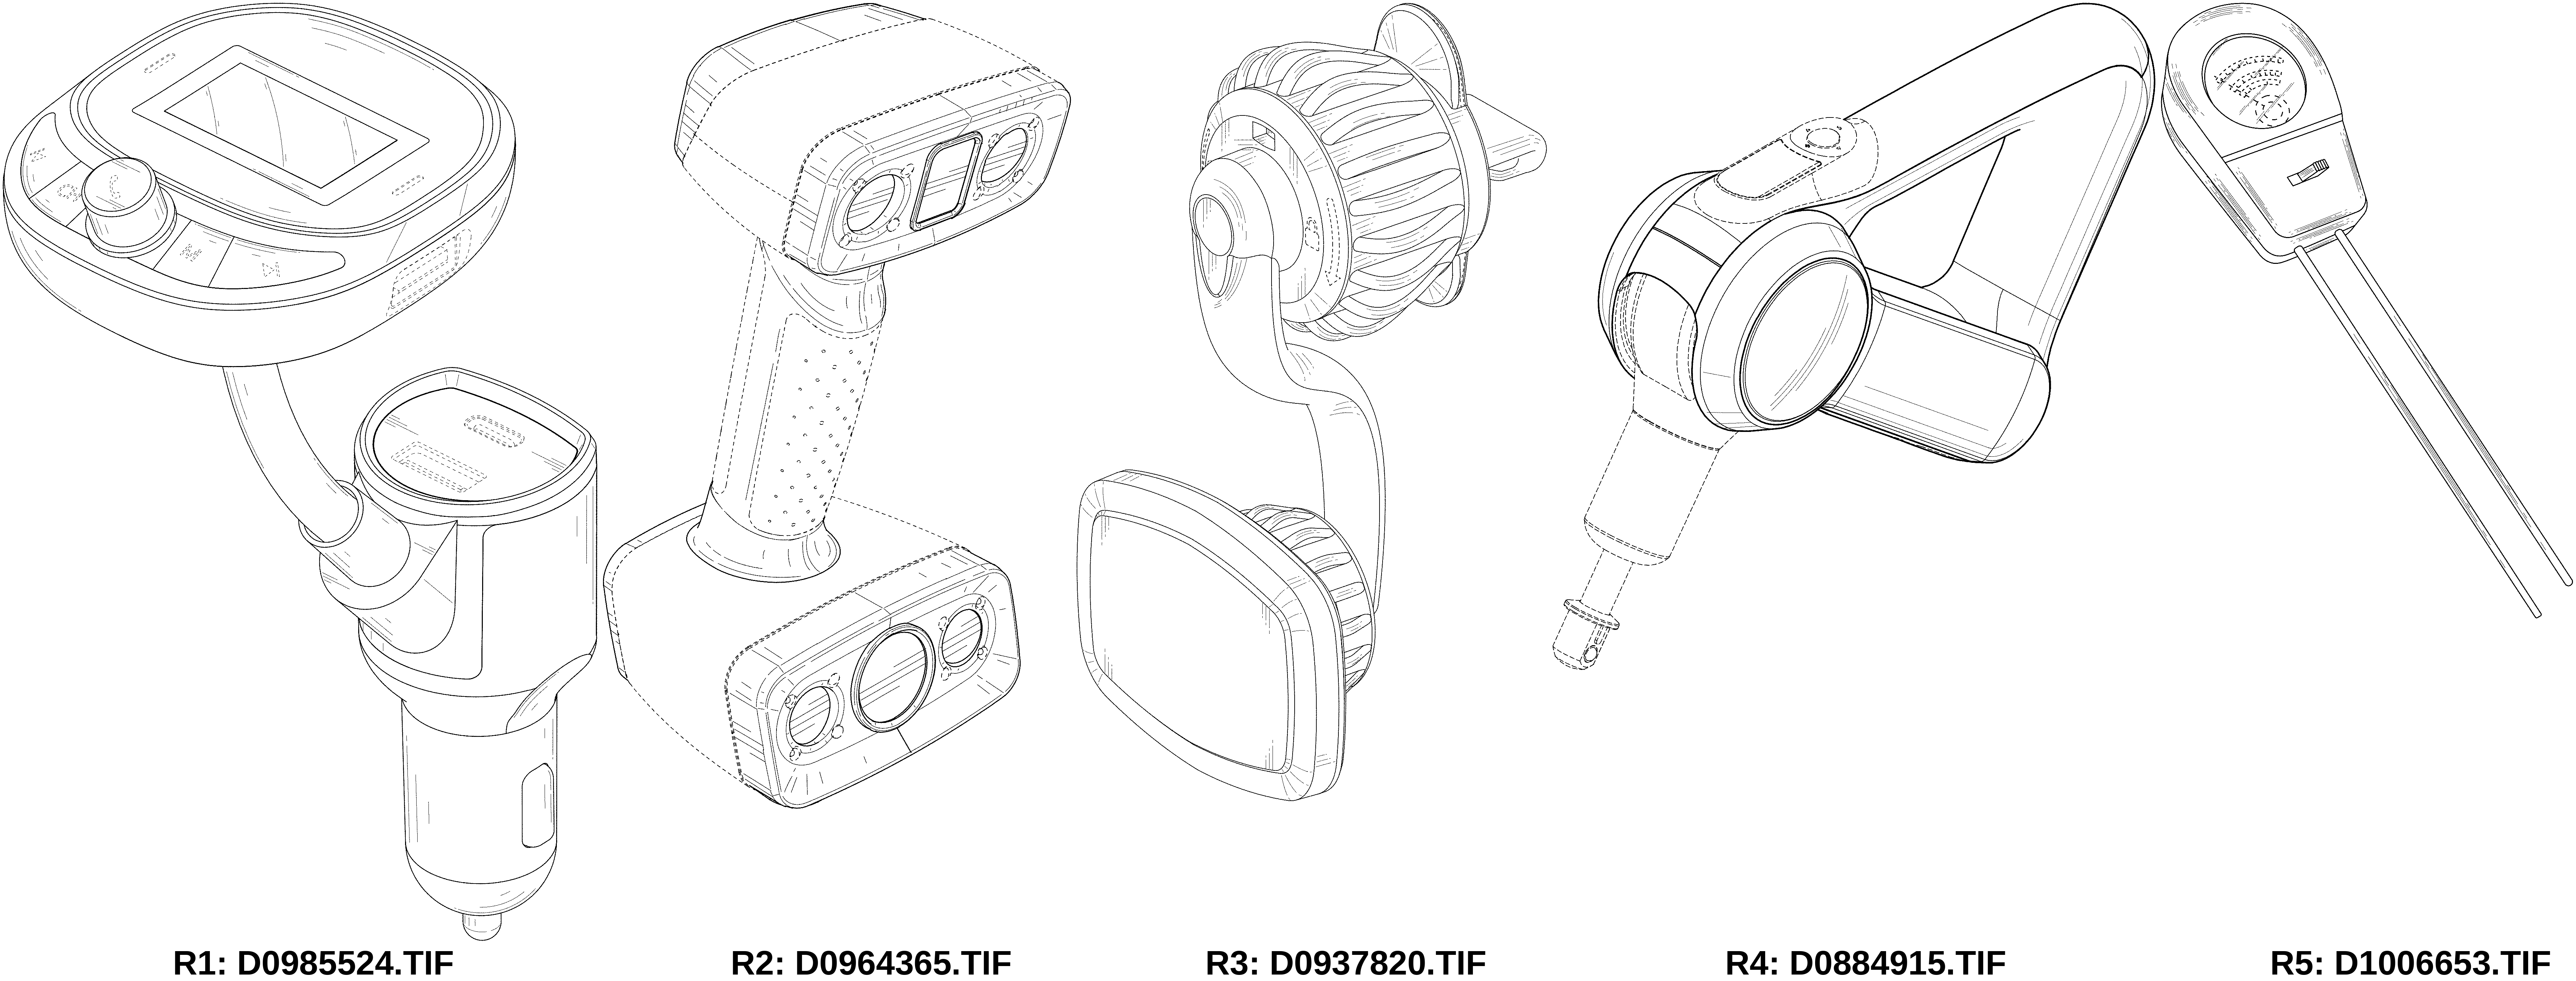

In [84]:
target = "The image is a white drawing of an FM transmitter, which is a device used to transmit audio signals through the air using frequency modulation (FM) technology. "
model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:ellen625/PatentCLIP_ViT_B', device=device)
tokenizer = open_clip.get_tokenizer('hf-hub:ellen625/PatentCLIP_ViT_B')
text_embedding_pc1 = get_single_text_embedding(target)

top_similar_images_pc1 = get_top_similar(embedded_images_pc1, text_embedding_pc1)
top_k_match_name_pc1 = [f"R{i+1}: {f.replace('val_images/', '')}" for i, f in enumerate(top_similar_images_pc1)]
top_k_match_images_pc1 = [Image.open(f) for f in top_similar_images_pc1]
combine_images_side_by_side(top_k_match_images_pc1,top_k_match_name_pc1)

# **TOP-5 Retrieval of PatentCLIP-Title:**

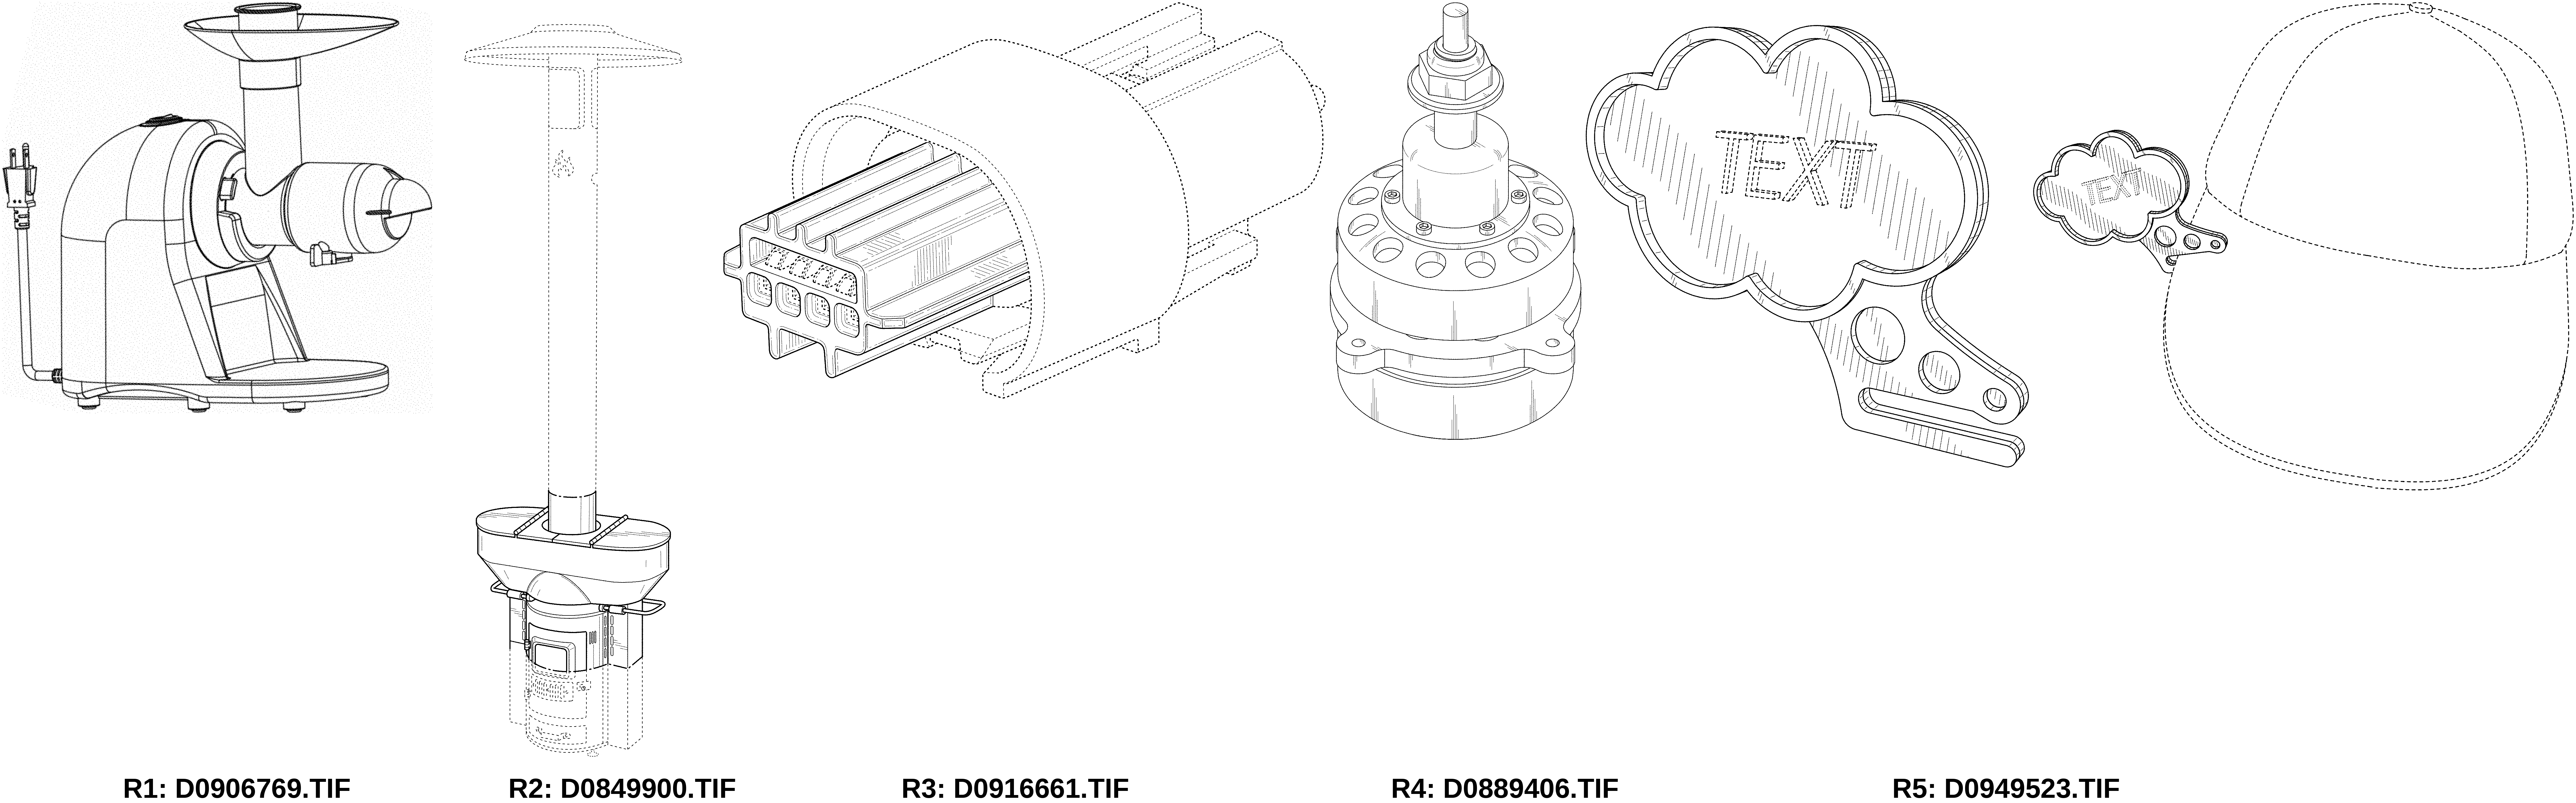

In [85]:
target = "The image is a white drawing of an FM transmitter, which is a device used to transmit audio signals through the air using frequency modulation (FM) technology."
model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:ellen625/PatentCLIP_ViT_B_title', device=device)
tokenizer = open_clip.get_tokenizer('hf-hub:ellen625/PatentCLIP_ViT_B_title')
text_embedding_pc2 = get_single_text_embedding(target)

top_similar_images_pc2 = get_top_similar(embedded_images_pc2, text_embedding_pc2)
top_k_match_name_pc2 = [f"R{i+1}: {f.replace('val_images/', '')}" for i, f in enumerate(top_similar_images_pc2)]
top_k_match_images_pc2 = [Image.open(f) for f in top_similar_images_pc2]
combine_images_side_by_side(top_k_match_images_pc2,top_k_match_name_pc2)

# Evaluation of Text-image retrieval (R@5)

In [20]:
import torch.utils.data as data

image_root = 'val_images/'
caption_file = 'val_caption_5k.csv'


class local_dataset(data.Dataset):
    def __init__(self):
        self.image_root = image_root
        self.caption_file = caption_file

    def __getitem__(self, index):
        df = pd.read_csv(self.caption_file)
        df['filepath'] = df['filepath'].str.replace('val/', '', n=1)
        caption = df['caption'][index]
        image_name = df['filepath'][index]
        image = Image.open(image_name)


        return image, caption

In [21]:
dataset = local_dataset()

In [74]:
img_feature_list = []
text_feature_list = []

df = pd.read_csv(caption_file)
df['filepath'] = df['filepath'].str.replace('val/', '', n=1)
k = 5

model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:ellen625/PatentCLIP_ViT_B', device=device)

with torch.no_grad():
    for i in tqdm(range(len(df))):
        caption = df['caption'][i]
        #text_list.append(caption)
        image_name = df['filepath'][i]
        image = Image.open(image_name)
        image = preprocess(image).unsqueeze(0).to(device)
        img_feature = model.encode_image(image)
        img_feature_list.append(img_feature)

        tokenizer = open_clip.get_tokenizer('hf-hub:ellen625/PatentCLIP_ViT_B')
        text_feature = tokenizer(caption).to(device)
        text_feature = model.encode_text(text_feature)
        text_feature_list.append(text_feature)

    image_embeds = torch.cat(img_feature_list, dim=0)
    image_embeds /= image_embeds.norm(dim=-1, keepdim=True)

    text_embeds = torch.cat(text_feature_list, dim=0)
    text_embeds /= text_embeds.norm(dim=-1, keepdim=True)

    print("Text to image retrieval:")
    correct_text_image = 0
    correct_list=[]
    c = []
    for j, text in enumerate(text_embeds):
        sim = text @ image_embeds.T
        topk_values, topk_indices = torch.topk(sim, k)
        if j in topk_indices:
            correct_text_image += 1
            correct_list.append(j)
            #print(f"Text {i}: Top {k} matching images:", topk_indices.tolist())
print(f"Top-{k} Recall for Text-to-Image: {correct_text_image /5000}")

Text to image retrieval:
Top-5 Recall for Text-to-Image: 0.255
